# BA2 plume analysis - Tanager + EnMAP (single MF + CMF)


In [1]:

import sys
import math
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
from osgeo import gdal, ogr, osr
from pyproj import CRS
import geopandas as gpd
import matplotlib.pyplot as plt

NOTEBOOK_ROOT = Path.cwd().resolve()
REPO_ROOT = NOTEBOOK_ROOT.parent
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

from scripts import plumes_analyzer
from scripts.satellites import enmap_utils, prisma_utils, tanager_utils


## Configure case paths, winds, and spectral assets

In [2]:
BASE_DATA_DIR = Path("/mnt/d/case_studies_tanager/BuenosAires")
OUTPUT_BASE = NOTEBOOK_ROOT / "outputs" / "ba2_single_mf_cmf"
OUTPUT_BASE.mkdir(parents=True, exist_ok=True)

# CWCMF (full-column) outputs
TANAGER_CWCMF_CONC = BASE_DATA_DIR / "Tanager/20250626_144419_75_4001/full-column/basic_radiance_hdf5__20250626_144419_75_4001_basic_radiance_hdf5_full-column_MF.tif"
TANAGER_CWCMF_UNC = BASE_DATA_DIR / "Tanager/20250626_144419_75_4001/full-column/basic_radiance_hdf5__20250626_144419_75_4001_basic_radiance_hdf5_full-column_MF_uncertainty.tif"
TANAGER_L1 = BASE_DATA_DIR / "Tanager/20250626_144419_75_4001/basic_radiance_hdf5__20250626_144419_75_4001_basic_radiance_hdf5.h5"

ENMAP_CWCMF_CONC = BASE_DATA_DIR / "EnMAP/ENMAP01-____L1B-DT0000064332_20240309T142431Z_014_V010505_20260109T195319Z/full-column/L1B_DT0000064332_014_20240309T142431Z_20240309T142436Z_full-column_MF.tif"
ENMAP_CWCMF_UNC = BASE_DATA_DIR / "EnMAP/ENMAP01-____L1B-DT0000064332_20240309T142431Z_014_V010505_20260109T195319Z/full-column/L1B_DT0000064332_014_20240309T142431Z_20240309T142436Z_full-column_MF_uncertainty.tif"
ENMAP_VNIR = BASE_DATA_DIR / "EnMAP/ENMAP01-____L1B-DT0000064332_20240309T142431Z_014_V010505_20260109T195319Z/ENMAP01-____L1B-DT0000064332_20240309T142431Z_014_V010505_20260109T195319Z-SPECTRAL_IMAGE_VNIR.TIF"
ENMAP_SWIR = BASE_DATA_DIR / "EnMAP/ENMAP01-____L1B-DT0000064332_20240309T142431Z_014_V010505_20260109T195319Z/ENMAP01-____L1B-DT0000064332_20240309T142431Z_014_V010505_20260109T195319Z-SPECTRAL_IMAGE_SWIR.TIF"
ENMAP_METADATA = BASE_DATA_DIR / "EnMAP/ENMAP01-____L1B-DT0000064332_20240309T142431Z_014_V010505_20260109T195319Z/ENMAP01-____L1B-DT0000064332_20240309T142431Z_014_V010505_20260109T195319Z-METADATA.XML"

# CMF (srf-column_k1) outputs
TANAGER_CMF_CONC = BASE_DATA_DIR / "Tanager/20250626_144419_75_4001/srf-column_k1/basic_radiance_hdf5__20250626_144419_75_4001_basic_radiance_hdf5_srf-column_k1_MF.tif"
TANAGER_CMF_UNC = BASE_DATA_DIR / "Tanager/20250626_144419_75_4001/srf-column_k1/basic_radiance_hdf5__20250626_144419_75_4001_basic_radiance_hdf5_srf-column_k1_MF_uncertainty.tif"

ENMAP_CMF_CONC = BASE_DATA_DIR / "EnMAP/ENMAP01-____L1B-DT0000064332_20240309T142431Z_014_V010505_20260109T195319Z/srf-column_k1/L1B_DT0000064332_014_20240309T142431Z_20240309T142436Z_srf-column_k1_MF.tif"
ENMAP_CMF_UNC = BASE_DATA_DIR / "EnMAP/ENMAP01-____L1B-DT0000064332_20240309T142431Z_014_V010505_20260109T195319Z/srf-column_k1/L1B_DT0000064332_014_20240309T142431Z_20240309T142436Z_srf-column_k1_MF_uncertainty.tif"

CASE_WINDS = {
    "tanager": {"u10": 1.95, "sigma_u10": 1.0},
    "enmap": {"u10": 2.68, "sigma_u10": 1.0},
}

CASES = [
    {
        "label": "tanager_cwcmf",
        "scene": "BA2 Tanager CWCMF (full-column)",
        "sensor_type": "TANAGER",
        "unit": "ppm-m",
        "concentration_file": TANAGER_CWCMF_CONC,
        "uncertainty_file": TANAGER_CWCMF_UNC,
        "vector_path": TANAGER_CWCMF_CONC.parent / "plume_segmentation_scaled" / "*" / f"{TANAGER_CWCMF_CONC.stem}_plumes_scaled.geojson",
        "wind": CASE_WINDS["tanager"],
        "gsd": None,
        "spectral_assets": {
            "sensor": "tanager",
            "l1": TANAGER_L1,
            "dataset_path": tanager_utils.TANAGER_TOA_RADIANCE_DATASET,
        },
    },
    {
        "label": "enmap_cwcmf",
        "scene": "BA2 EnMAP CWCMF (full-column)",
        "sensor_type": "ENMAP",
        "unit": "ppm-m",
        "concentration_file": ENMAP_CWCMF_CONC,
        "uncertainty_file": ENMAP_CWCMF_UNC,
        "vector_path": ENMAP_CWCMF_CONC.parent / "plume_segmentation_scaled" / "*" / f"{ENMAP_CWCMF_CONC.stem}_plumes_scaled.geojson",
        "wind": CASE_WINDS["enmap"],
        "gsd": 30,
        "spectral_assets": {
            "sensor": "enmap",
            "vnir": ENMAP_VNIR,
            "swir": ENMAP_SWIR,
            "metadata": ENMAP_METADATA,
        },
    },
    {
        "label": "tanager_cmf",
        "scene": "BA2 Tanager CMF (srf-column_k1)",
        "sensor_type": "TANAGER",
        "unit": "ppm-m",
        "concentration_file": TANAGER_CMF_CONC,
        "uncertainty_file": TANAGER_CMF_UNC,
        "vector_path": TANAGER_CWCMF_CONC.parent / "plume_segmentation_scaled" / "*" / f"{TANAGER_CWCMF_CONC.stem}_plumes_scaled.geojson",
        "wind": CASE_WINDS["tanager"],
        "gsd": None,
        "spectral_assets": {
            "sensor": "tanager",
            "l1": TANAGER_L1,
            "dataset_path": tanager_utils.TANAGER_TOA_RADIANCE_DATASET,
        },
    },
    {
        "label": "enmap_cmf",
        "scene": "BA2 EnMAP CMF (srf-column_k1)",
        "sensor_type": "ENMAP",
        "unit": "ppm-m",
        "concentration_file": ENMAP_CMF_CONC,
        "uncertainty_file": ENMAP_CMF_UNC,
        "vector_path": ENMAP_CWCMF_CONC.parent / "plume_segmentation_scaled" / "*" / f"{ENMAP_CWCMF_CONC.stem}_plumes_scaled.geojson",
        "wind": CASE_WINDS["enmap"],
        "gsd": 30,
        "spectral_assets": {
            "sensor": "enmap",
            "vnir": ENMAP_VNIR,
            "swir": ENMAP_SWIR,
            "metadata": ENMAP_METADATA,
        },
    },
]

print(f"Configured {len(CASES)} cases")
for case in CASES:
    print(f" - {case['label']}: {case['concentration_file']}")



Configured 4 cases
 - tanager_cwcmf: /mnt/d/case_studies_tanager/BuenosAires/Tanager/20250626_144419_75_4001/full-column/basic_radiance_hdf5__20250626_144419_75_4001_basic_radiance_hdf5_full-column_MF.tif
 - enmap_cwcmf: /mnt/d/case_studies_tanager/BuenosAires/EnMAP/ENMAP01-____L1B-DT0000064332_20240309T142431Z_014_V010505_20260109T195319Z/full-column/L1B_DT0000064332_014_20240309T142431Z_20240309T142436Z_full-column_MF.tif
 - tanager_cmf: /mnt/d/case_studies_tanager/BuenosAires/Tanager/20250626_144419_75_4001/srf-column_k1/basic_radiance_hdf5__20250626_144419_75_4001_basic_radiance_hdf5_srf-column_k1_MF.tif
 - enmap_cmf: /mnt/d/case_studies_tanager/BuenosAires/EnMAP/ENMAP01-____L1B-DT0000064332_20240309T142431Z_014_V010505_20260109T195319Z/srf-column_k1/L1B_DT0000064332_014_20240309T142431Z_20240309T142436Z_srf-column_k1_MF.tif


## Lightweight run reporter

In [3]:

SAVE_RUN_REPORT = True
REPORT_FILE = OUTPUT_BASE / "plume_analysis_run_report.md"
REPORT_ASSETS_DIR = OUTPUT_BASE / "assets"

class RunReporter:
    def __init__(self, enabled, report_path, assets_dir, title='Plume Analysis Run Report'):
        self.enabled = bool(enabled)
        self.report_path = Path(report_path) if report_path else None
        self.assets_dir = Path(assets_dir) if assets_dir else None
        self.title = title
        self.blocks = []
        if self.enabled:
            self.assets_dir.mkdir(parents=True, exist_ok=True)

    def log_block(self, heading, lines):
        if not self.enabled:
            return
        block = [f"### {heading}"] + [f"- {line}" for line in lines]
        self.blocks.append("".join(block))

    def save(self):
        if not self.enabled or not self.report_path:
            return
        content = [f"# {self.title}"] + self.blocks
        self.report_path.write_text("".join(content), encoding="utf-8")
        print(f"Report written to {self.report_path}")

reporter = RunReporter(SAVE_RUN_REPORT, REPORT_FILE, REPORT_ASSETS_DIR, title="BA2 plume analysis")


## Helper functions

In [4]:

from scipy.spatial import cKDTree


def pixel_size_m(gt, projection_wkt, height, width):
    res_x, res_y = gt[1], gt[5]
    try:
        crs = CRS.from_wkt(projection_wkt) if projection_wkt else None
    except Exception:
        crs = None
    if crs is not None and getattr(crs, "is_geographic", False):
        cy = gt[3] + (height / 2) * res_y + gt[4] * (width / 2)
        meters_per_deg_lat = 111132.92
        meters_per_deg_lon = (
            111412.84 * math.cos(math.radians(cy))
            - 93.5 * math.cos(3 * math.radians(cy))
            + 0.118 * math.cos(5 * math.radians(cy))
        )
        px = abs(res_x) * meters_per_deg_lon
        py = abs(res_y) * meters_per_deg_lat
    else:
        px = abs(res_x)
        py = abs(res_y)
    pixel_size_m = float(np.mean([px, py]))
    return max(pixel_size_m, 1e-3)


def load_case_arrays(concentration_file, uncertainty_file):
    conc_arr, geotransform, projection, _ = plumes_analyzer.load_geotiff(str(concentration_file))
    unc_arr, _, _, _ = plumes_analyzer.load_geotiff(str(uncertainty_file))
    return conc_arr, unc_arr, geotransform, projection


def convert_units(conc_arr, unc_arr, unit):
    conc_clean = plumes_analyzer.discard_neg(conc_arr)
    unc_clean = plumes_analyzer.discard_neg(unc_arr)
    if unit == 'ppm-m':
        return plumes_analyzer.ppm_m_to_ppb(conc_clean), plumes_analyzer.ppm_m_to_ppb(unc_clean)
    return conc_clean, unc_clean


def clean_clip(arr, nodata_val=-9999):
    arr = np.array(arr, dtype=float)
    if nodata_val is not None:
        arr[arr == nodata_val] = np.nan
    arr[~np.isfinite(arr)] = np.nan
    arr[arr <= 0] = np.nan
    return arr


def rasterize_gdf(gdf, geo_transform, projection, shape):
    rows, cols = shape
    drv = ogr.GetDriverByName('Memory')
    ds = drv.CreateDataSource('')
    srs = osr.SpatialReference()
    if projection:
        srs.ImportFromWkt(projection)
    layer = ds.CreateLayer('plume', srs=srs, geom_type=ogr.wkbPolygon)
    defn = layer.GetLayerDefn()
    for geom in gdf.geometry:
        if geom is None or geom.is_empty:
            continue
        feat = ogr.Feature(defn)
        feat.SetGeometry(ogr.CreateGeometryFromWkb(geom.wkb))
        layer.CreateFeature(feat)
        feat = None
    mask_ds = gdal.GetDriverByName('MEM').Create('', cols, rows, 1, gdal.GDT_Byte)
    mask_ds.SetGeoTransform(geo_transform)
    if projection:
        mask_ds.SetProjection(projection)
    gdal.RasterizeLayer(mask_ds, [1], layer, burn_values=[1])
    mask = mask_ds.ReadAsArray().astype(bool)
    mask_ds = None
    ds = None
    return mask


def band_mask(wavelengths, windows, guard_nm):
    wav = np.asarray(wavelengths, dtype=float).ravel()
    mask = np.ones_like(wav, dtype=bool)
    for lo, hi in windows:
        mask &= ~((wav >= (lo - guard_nm)) & (wav <= (hi + guard_nm)))
    return mask


def spectral_distance(cube, ref_mean, ref_std):
    standardized = (cube - ref_mean) / ref_std
    return np.sqrt(np.nanmean(standardized ** 2, axis=2))


def select_background(distance_map, candidate_mask, percentiles, min_fraction, min_pixels, fallback_percentile=70.0):
    candidate_values = distance_map[candidate_mask]
    if candidate_values.size == 0:
        return candidate_mask & False, None, None
    min_required = max(int(np.ceil(candidate_values.size * min_fraction)), int(min_pixels))
    for perc in percentiles:
        threshold = float(np.nanpercentile(candidate_values, perc))
        mask = (distance_map <= threshold) & candidate_mask
        if mask.sum() >= min_required:
            return mask, threshold, perc
    threshold = float(np.nanpercentile(candidate_values, fallback_percentile))
    mask = (distance_map <= threshold) & candidate_mask
    return mask, threshold, fallback_percentile


def load_spectral_cube(assets):
    if assets is None:
        raise ValueError('Spectral assets are required to load a cube.')
    if 'cube' in assets and 'wavelengths' in assets:
        return np.asarray(assets['cube'], dtype=np.float32), np.asarray(assets['wavelengths'], dtype=np.float32)
    sensor = assets.get('sensor', 'enmap').lower()
    if sensor == 'prisma':
        cube, cw_matrix, *_ = prisma_utils.prisma_read(str(assets['l1']))
        wavelengths = np.mean(cw_matrix, axis=0).astype(np.float32)
        cube = np.rot90(cube, k=1).astype(np.float32)
        return cube, wavelengths
    if sensor == 'enmap':
        cube, wavelengths, _, _, _, _ = enmap_utils.enmap_read(
            str(assets['vnir']), str(assets['swir']), str(assets.get('metadata')) if assets.get('metadata') else None
        )
        return cube.astype(np.float32), np.asarray(wavelengths, dtype=np.float32)
    if sensor == 'tanager':
        cube = tanager_utils.load_tanager_cube(
            str(assets['l1']),
            dataset_path=assets.get('dataset_path', tanager_utils.TANAGER_TOA_RADIANCE_DATASET),
            load_masks=False,
            load_geolocation=False,
        )
        data = np.moveaxis(cube.data, 0, -1)
        wavelengths = cube.wavelengths if cube.wavelengths is not None else np.arange(data.shape[2])
        return data.astype(np.float32), np.asarray(wavelengths, dtype=np.float32)
    raise ValueError(f"Unsupported sensor for spectral assets: {sensor}")


def reproject_tanager_cube_to_target(h5_path, dataset_path, target_gt, target_proj, target_shape):
    cube = tanager_utils.load_tanager_cube(
        str(h5_path), dataset_path=dataset_path, load_masks=False, load_geolocation=True, dtype=np.float32
    )
    if not cube.geolocation or 'latitude' not in cube.geolocation or 'longitude' not in cube.geolocation:
        raise ValueError('Tanager cube missing latitude/longitude for reprojection')
    lat_src = np.asarray(cube.geolocation['latitude'], dtype=np.float32)
    lon_src = np.asarray(cube.geolocation['longitude'], dtype=np.float32)
    src_rows, src_cols = lat_src.shape
    pts = np.column_stack((lon_src.ravel(), lat_src.ravel()))
    tree = cKDTree(pts)

    rows = np.arange(target_shape[0])
    cols = np.arange(target_shape[1])
    rr, cc = np.meshgrid(rows, cols, indexing='ij')
    x = target_gt[0] + cc * target_gt[1] + rr * target_gt[2]
    y = target_gt[3] + cc * target_gt[4] + rr * target_gt[5]

    from pyproj import CRS, Transformer
    tgt_crs = CRS.from_wkt(target_proj) if target_proj else None
    if tgt_crs and not tgt_crs.is_geographic:
        to_geo = Transformer.from_crs(tgt_crs, CRS.from_epsg(4326), always_xy=True)
        lon_tgt, lat_tgt = to_geo.transform(x, y)
    else:
        lon_tgt, lat_tgt = x, y

    idx = tree.query(np.column_stack((lon_tgt.ravel(), lat_tgt.ravel())), k=1)[1]
    data = np.moveaxis(cube.data, 0, -1)  # H,W,B
    bands = data.shape[2]
    out = np.full((target_shape[0], target_shape[1], bands), np.nan, dtype=np.float32)
    flat_out = out.reshape(-1, bands)
    flat_data = data.reshape(-1, bands)
    flat_out[:] = flat_data[idx]
    wavelengths = cube.wavelengths if cube.wavelengths is not None else np.arange(bands, dtype=np.float32)
    return out, wavelengths


def estimate_sigma_surf(
    concentration_ppb,
    uncertainty_ppb,
    plume_mask,
    finite_mask,
    spectral_assets=None,
    methane_windows=((1500.0, 1700.0), (2100.0, 2450.0)),
    guard_nm=8.0,
    percentiles=(10, 15, 20, 30, 40, 50),
    min_fraction=0.01,
    min_pixels=750,
):
    plume_mask = plume_mask & finite_mask
    plume_free = (~plume_mask) & finite_mask
    background_mask = plume_free
    info = {
        'background_pixels': int(plume_free.sum()),
        'spectral_percentile': None,
        'spectral_threshold': None,
    }
    if spectral_assets:
        try:
            cube, wavelengths = load_spectral_cube(spectral_assets)
            usable = band_mask(wavelengths, methane_windows, guard_nm)
            if not np.any(usable):
                raise ValueError('No usable bands after methane-window masking')
            cube = cube[:, :, usable]
            finite_cube = np.all(np.isfinite(cube), axis=2)
            ref_pixels = cube[plume_mask & finite_cube]
            if ref_pixels.size == 0:
                raise ValueError('No finite plume pixels available for spectral reference')
            ref_mean = np.nanmedian(ref_pixels, axis=0)
            ref_std = np.nanstd(ref_pixels, axis=0, ddof=1)
            ref_std = np.where(ref_std > 0, ref_std, 1.0)
            dist_map = spectral_distance(cube, ref_mean, ref_std)
            candidate = plume_free & finite_cube & np.isfinite(dist_map)
            bg_mask, threshold, perc = select_background(dist_map, candidate, percentiles, min_fraction, min_pixels)
            if np.any(bg_mask):
                background_mask = bg_mask
                info.update({
                    'background_pixels': int(background_mask.sum()),
                    'spectral_percentile': perc,
                    'spectral_threshold': threshold,
                })
        except Exception as exc:  # noqa: BLE001
            info['note'] = str(exc)

    if not np.any(background_mask):
        background_mask = plume_free

    sigma_tot = float(np.nanstd(concentration_ppb[background_mask], ddof=1))
    sigma_rmn_sq = float(np.nanmean(np.square(uncertainty_ppb[background_mask])))
    sigma_surf = float(np.sqrt(max(0.0, sigma_tot ** 2 - sigma_rmn_sq)))
    info.update({'sigma_tot_ppb': sigma_tot, 'sigma_rmn_sq': sigma_rmn_sq, 'sigma_surf_ppb': sigma_surf})
    return sigma_surf, background_mask, info


def analyze_case(case_cfg, reporter, output_dir):
    output_dir.mkdir(parents=True, exist_ok=True)
    conc_raw, unc_raw, gt, proj = load_case_arrays(case_cfg['concentration_file'], case_cfg['uncertainty_file'])
    if case_cfg['unit'] == 'ppm-m':
        conc_bg_ppb = plumes_analyzer.ppm_m_to_ppb(conc_raw)
        unc_bg_ppb = plumes_analyzer.ppm_m_to_ppb(unc_raw)
    else:
        conc_bg_ppb = np.array(conc_raw, dtype=float)
        unc_bg_ppb = np.array(unc_raw, dtype=float)
    conc_ppb, unc_ppb = convert_units(conc_raw, unc_raw, case_cfg['unit'])
    gsd = case_cfg.get('gsd') or pixel_size_m(gt, proj, conc_raw.shape[0], conc_raw.shape[1])

    gdf = gpd.read_file(case_cfg['vector_path'])
    if '*' in str(case_cfg['vector_path']):
        raise FileNotFoundError(f"Expand the glob in vector_path: {case_cfg['vector_path']}")
    _, _, raster_wkt, _ = plumes_analyzer.load_geotiff(str(case_cfg['concentration_file']))
    raster_crs = CRS.from_wkt(raster_wkt)
    gdf_raster = gdf.to_crs(raster_crs)
    projected_gdf, projected_epsg = plumes_analyzer.project_gdf_to_local_utm(gdf)

    cfg_for_bg = case_cfg
    if case_cfg['sensor_type'] == 'TANAGER':
        cube_reproj, wav = reproject_tanager_cube_to_target(
            case_cfg['spectral_assets']['l1'],
            case_cfg['spectral_assets'].get('dataset_path', tanager_utils.TANAGER_TOA_RADIANCE_DATASET),
            gt,
            proj,
            conc_ppb.shape,
        )
        cfg_for_bg = dict(case_cfg)
        cfg_for_bg['spectral_assets'] = {'cube': cube_reproj, 'wavelengths': wav}

    plume_mask_geo = rasterize_gdf(gdf_raster, gt, proj, conc_ppb.shape)
    finite_mask_bg = np.isfinite(conc_bg_ppb) & np.isfinite(unc_bg_ppb)
    sigma_surf_ppb, background_mask, bg_info = estimate_sigma_surf(
        conc_bg_ppb,
        unc_bg_ppb,
        plume_mask_geo,
        finite_mask_bg,
        spectral_assets=cfg_for_bg.get('spectral_assets'),
        methane_windows=cfg_for_bg.get('methane_windows_nm', ((1500.0, 1700.0), (2100.0, 2450.0))),
    )

    plumes = []
    for idx, (row_raster, row_proj) in enumerate(zip(gdf_raster.itertuples(), projected_gdf.itertuples()), start=1):
        poly = row_raster.geometry
        clip_conc_path = output_dir / f"{case_cfg['label']}_plume{idx}_conc.tif"
        clip_unc_path = output_dir / f"{case_cfg['label']}_plume{idx}_unc.tif"
        clipped_conc = plumes_analyzer.clip_raster_to_polygon(str(case_cfg['concentration_file']), poly, str(clip_conc_path))
        clipped_unc = plumes_analyzer.clip_raster_to_polygon(str(case_cfg['uncertainty_file']), poly, str(clip_unc_path))
        clipped_conc = clean_clip(clipped_conc, nodata_val=-9999)
        clipped_unc = clean_clip(clipped_unc, nodata_val=-9999)
        clipped_conc_ppb, clipped_unc_ppb = convert_units(clipped_conc, clipped_unc, case_cfg['unit'])
        clipped_unc_total_ppb = np.sqrt(np.square(clipped_unc_ppb) + sigma_surf_ppb ** 2)
        stats = plumes_analyzer.compute_plume_stats(clipped_conc_ppb)

        area_m2 = row_proj.geometry.area
        pixel_count = int(round(area_m2 / (gsd ** 2)))
        L = math.sqrt(area_m2)
        wind = case_cfg['wind']
        u_eff, a_coeff, _ = plumes_analyzer.compute_u_eff(wind['u10'], case_cfg['sensor_type'])
        ime = plumes_analyzer.calculate_ime(clipped_conc_ppb, gsd)
        sigma_ime = plumes_analyzer.calculate_sigma_ime(clipped_unc_total_ppb, gsd)
        sigma_ime_instr = plumes_analyzer.calculate_sigma_ime(clipped_unc_ppb, gsd)
        sigma_ime_surf = plumes_analyzer.calculate_sigma_ime(np.full_like(clipped_unc_ppb, sigma_surf_ppb), gsd) if sigma_surf_ppb > 0 else 0.0
        q = plumes_analyzer.compute_flux(ime, u_eff, L)
        sigma_q, sigma_q_ime, sigma_q_wind = plumes_analyzer.propagate_flux_uncertainty(
            q, ime, sigma_ime, wind['u10'], wind['sigma_u10'], u_eff, a_coeff
        )
        sigma_q_instr = q * (sigma_ime_instr / ime) if ime > 0 else 0.0
        sigma_q_surf = q * (sigma_ime_surf / ime) if ime > 0 else 0.0
        sigma_q_ime_total = math.sqrt(sigma_q_instr ** 2 + sigma_q_surf ** 2)
        sigma_q_total = math.sqrt(sigma_q_ime_total ** 2 + sigma_q_wind ** 2)

        plumes.append(
            {
                'plume_id': idx,
                'area_m2': area_m2,
                'pixel_count': pixel_count,
                'L': L,
                'u_eff': u_eff,
                'ime': ime,
                'sigma_ime': sigma_ime,
                'sigma_ime_instr': sigma_ime_instr,
                'sigma_ime_surf': sigma_ime_surf,
                'sigma_surf_ppb': sigma_surf_ppb,
                'sigma_surf_meta': bg_info,
                'q': q,
                'sigma_q': sigma_q_total,
                'sigma_q_ime': sigma_q_ime_total,
                'sigma_q_instr': sigma_q_instr,
                'sigma_q_surf': sigma_q_surf,
                'sigma_q_wind': sigma_q_wind,
                'stats': stats,
                'clipped_conc_ppb': clipped_conc_ppb,
                'clipped_unc_ppb': clipped_unc_ppb,
                'clipped_unc_total_ppb': clipped_unc_total_ppb,
            },
        )

        reporter.log_block(
            f"{case_cfg['label']} plume {idx}",
            [
                f"Area: {area_m2:.2f} m^2 (approx {pixel_count} pixels @ {gsd} m)",
                f"IME: {ime:.2f} +/- {sigma_ime:.2f} kg",
                f"Flux: {q:.2f} +/- {sigma_q_total:.2f} t/h",
            ],
        )

    reporter.log_block(
        f"{case_cfg['label']} background",
        [
            f"sigma_surf: {sigma_surf_ppb:.2f} ppb",
            f"sigma_tot (conc std): {bg_info.get('sigma_tot_ppb'):.2f} ppb" if bg_info.get('sigma_tot_ppb') is not None else "sigma_tot (conc std): n/a",
            (
                f"sigma_rmn (propagated): {math.sqrt(bg_info.get('sigma_rmn_sq')):.2f} ppb"
                if bg_info.get('sigma_rmn_sq') is not None
                else "sigma_rmn (propagated): n/a"
            ),
            f"background pixels: {bg_info.get('background_pixels', 0)}",
            f"spectral percentile: {bg_info.get('spectral_percentile')}",
            f"note: {bg_info.get('note', 'n/a')}",
        ],
    )

    return {
        'label': case_cfg['label'],
        'scene': case_cfg['scene'],
        'sensor': case_cfg['sensor_type'],
        'unit': case_cfg['unit'],
        'gsd': gsd,
        'wind': case_cfg['wind'],
        'plumes': plumes,
        'concentration_raw': conc_raw,
        'concentration_ppb': conc_ppb,
        'uncertainty_raw': unc_raw,
        'uncertainty_ppb': unc_ppb,
        'geotransform': gt,
        'projection': proj,
        'vector_path': case_cfg['vector_path'],
        'sigma_surf_ppb': sigma_surf_ppb,
        'background_info': bg_info,
    }


def build_recap_table(results):
    rows = []
    for res in results:
        for plume in res['plumes']:
            rows.append(
                {
                    'sensor': res['sensor'],
                    'case': res['label'],
                    'plume_id': plume['plume_id'],
                    'pixels': plume['pixel_count'],
                    'area_m2': plume['area_m2'],
                    'IME_kg': plume['ime'],
                    'sigma_IME_kg': plume['sigma_ime'],
                    'sigma_IME_instr_kg': plume['sigma_ime_instr'],
                    'sigma_IME_surf_kg': plume['sigma_ime_surf'],
                    'Flux_tph': plume['q'],
                    'sigma_Flux_total_tph': plume['sigma_q'],
                    'sigma_Flux_ime_tph': plume['sigma_q_ime'],
                    'sigma_Flux_instr_tph': plume['sigma_q_instr'],
                    'sigma_Flux_surf_tph': plume['sigma_q_surf'],
                    'sigma_Flux_wind_tph': plume['sigma_q_wind'],
                },
            )
    df = pd.DataFrame(rows)
    if not df.empty:
        ordered_cols = [
            'sensor', 'case', 'plume_id', 'pixels', 'area_m2',
            'IME_kg', 'sigma_IME_kg', 'sigma_IME_instr_kg', 'sigma_IME_surf_kg',
            'Flux_tph', 'sigma_Flux_total_tph', 'sigma_Flux_ime_tph', 'sigma_Flux_instr_tph', 'sigma_Flux_surf_tph', 'sigma_Flux_wind_tph',
        ]
        df = df[ordered_cols]
    return df


def mosaic_plot(results, key, title, cmap='plasma', vmin=0, vmax=None, cols=3):
    n = len(results)
    cols = min(cols, n)
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3.6 * rows))
    axes = np.atleast_2d(axes)
    flat_axes = axes.flat

    fig.subplots_adjust(left=0.05, right=0.80, top=0.92, bottom=0.06, wspace=0.08, hspace=0.08)

    vmax = vmax if vmax is not None else max(float(np.nanmax(res[key])) for res in results)
    for ax, res in zip(flat_axes, results):
        arr = res[key]
        im = ax.imshow(np.ma.masked_invalid(arr), cmap=cmap, vmin=vmin, vmax=vmax)
        label = res['label']
        ax.set_title(label, fontsize=11)
        ax.axis('off')

    for ax in list(flat_axes)[n:]:
        ax.axis('off')

    cax = fig.add_axes([0.83, 0.15, 0.025, 0.65])
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.set_ylabel(title)

    fig.suptitle(title, fontsize=15)
    return fig


## Run the analyses

In [5]:
from glob import glob

all_results = []
for cfg in CASES:
    cfg = dict(cfg)
    vp = Path(cfg['vector_path'])
    if '*' in str(vp):
        matches = sorted(Path(p) for p in glob(str(vp)))
        if not matches:
            raise FileNotFoundError(f"No plume GeoJSON found for {cfg['label']} matching {vp}")
        cfg['vector_path'] = matches[-1]
    if not Path(cfg['vector_path']).exists():
        raise FileNotFoundError(f"Plume GeoJSON not found: {cfg['vector_path']}")

    print(f"Processing {cfg['label']} ...")
    case_dir = OUTPUT_BASE / cfg['label']
    res = analyze_case(cfg, reporter, case_dir)
    all_results.append(res)
    print(f" -> {len(res['plumes'])} plume(s) processed")

reporter.save()

Processing tanager_cwcmf ...


/home/esivla/miniconda3/envs/hygasMF/lib/python3.11/site-packages/osgeo/gdal.py:6123: RuntimeWarning: the source raster dataset has a SRS, but the cutline features
not.  We assume that the cutline coordinates are expressed in the destination SRS.
If not, cutline results may be incorrect.
  return _gdal.wrapper_GDALWarpDestName(*args)


 -> 1 plume(s) processed
Processing enmap_cwcmf ...


/home/esivla/miniconda3/envs/hygasMF/lib/python3.11/site-packages/osgeo/gdal.py:6123: RuntimeWarning: the source raster dataset has a SRS, but the cutline features
not.  We assume that the cutline coordinates are expressed in the destination SRS.
If not, cutline results may be incorrect.
  return _gdal.wrapper_GDALWarpDestName(*args)


 -> 1 plume(s) processed
Processing tanager_cmf ...


/home/esivla/miniconda3/envs/hygasMF/lib/python3.11/site-packages/osgeo/gdal.py:6123: RuntimeWarning: the source raster dataset has a SRS, but the cutline features
not.  We assume that the cutline coordinates are expressed in the destination SRS.
If not, cutline results may be incorrect.
  return _gdal.wrapper_GDALWarpDestName(*args)


 -> 1 plume(s) processed
Processing enmap_cmf ...
 -> 1 plume(s) processed
Report written to /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/ba2_single_mf_cmf/plume_analysis_run_report.md


/home/esivla/miniconda3/envs/hygasMF/lib/python3.11/site-packages/osgeo/gdal.py:6123: RuntimeWarning: the source raster dataset has a SRS, but the cutline features
not.  We assume that the cutline coordinates are expressed in the destination SRS.
If not, cutline results may be incorrect.
  return _gdal.wrapper_GDALWarpDestName(*args)


## Recap table

In [6]:

recap_df = build_recap_table(all_results)
recap_df.style.format({
    'area_m2': '{:,.0f}',
    'IME_kg': '{:.2f}',
    'sigma_IME_kg': '{:.2f}',
    'sigma_IME_instr_kg': '{:.2f}',
    'sigma_IME_surf_kg': '{:.2f}',
    'Flux_tph': '{:.2f}',
    'sigma_Flux_total_tph': '{:.2f}',
    'sigma_Flux_ime_tph': '{:.2f}',
    'sigma_Flux_instr_tph': '{:.2f}',
    'sigma_Flux_surf_tph': '{:.2f}',
    'sigma_Flux_wind_tph': '{:.2f}',
}).hide(axis='index')


sensor,case,plume_id,pixels,area_m2,IME_kg,sigma_IME_kg,sigma_IME_instr_kg,sigma_IME_surf_kg,Flux_tph,sigma_Flux_total_tph,sigma_Flux_ime_tph,sigma_Flux_instr_tph,sigma_Flux_surf_tph,sigma_Flux_wind_tph
TANAGER,tanager_cwcmf,1,21922,"24,653,251",30590.94,101.29,72.59,70.64,31.53,8.21,0.10,0.07,0.07,8.21
ENMAP,enmap_cwcmf,1,72643,"65,378,711",98858.52,481.67,37.82,480.18,74.02,16.29,0.36,0.03,0.36,16.29
TANAGER,tanager_cmf,1,21922,"24,653,251",52998.26,131.05,72.59,109.11,54.62,14.22,0.14,0.07,0.11,14.22
ENMAP,enmap_cmf,1,72643,"65,378,711",157106.26,560.93,37.82,559.65,117.63,25.88,0.42,0.03,0.42,25.88


## Quick-look mosaics

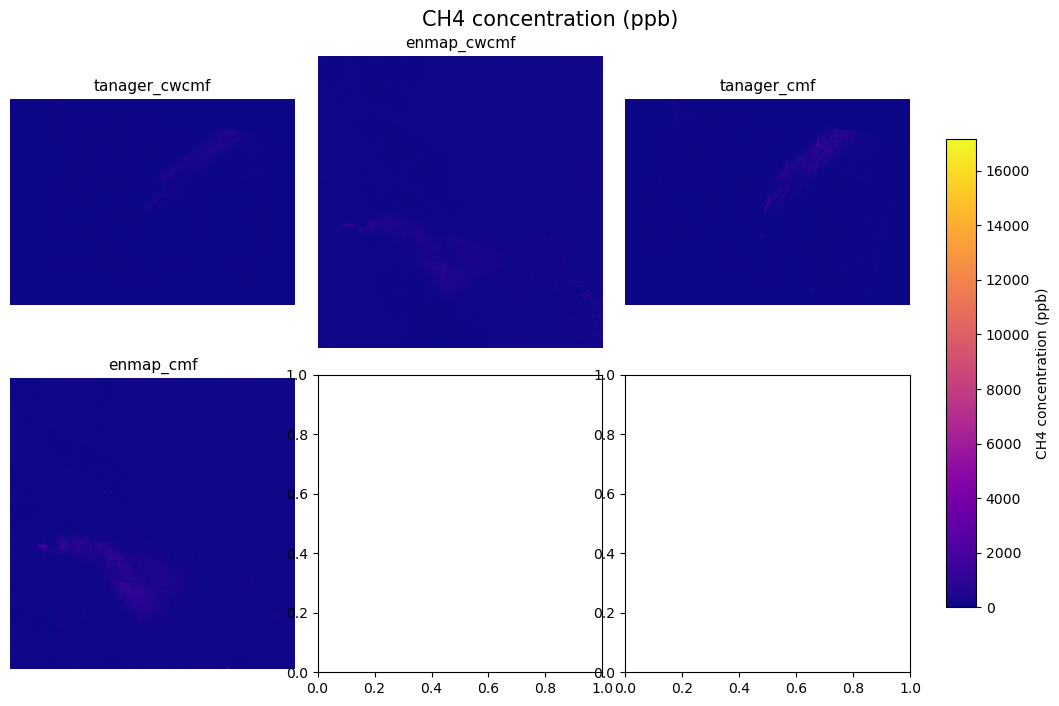

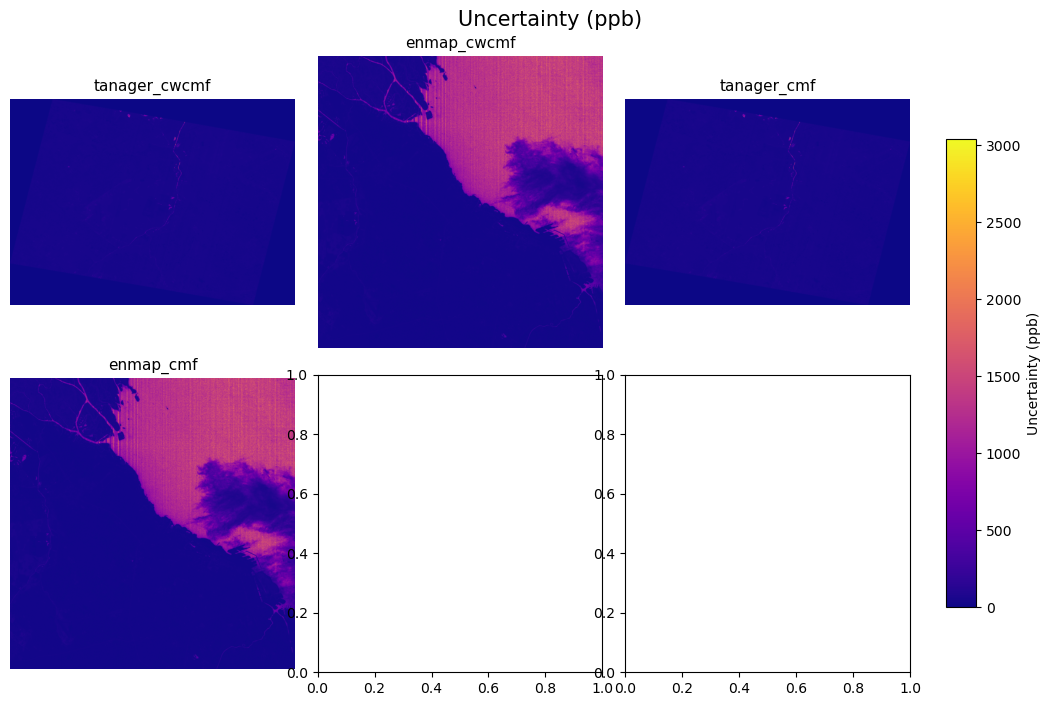

In [7]:

fig_conc = mosaic_plot(all_results, key='concentration_ppb', title='CH4 concentration (ppb)', vmin=0)
plt.show()

fig_unc = mosaic_plot(all_results, key='uncertainty_ppb', title='Uncertainty (ppb)', vmin=0)
plt.show()


## Plume overlays with contours

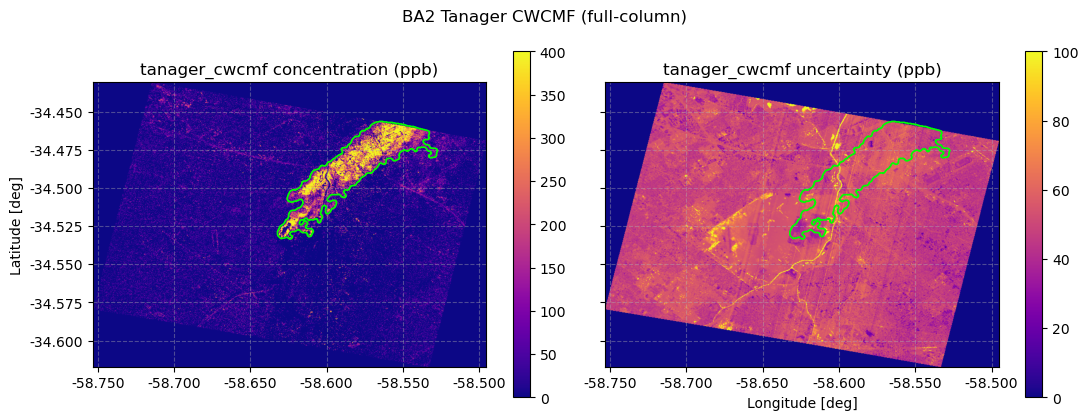

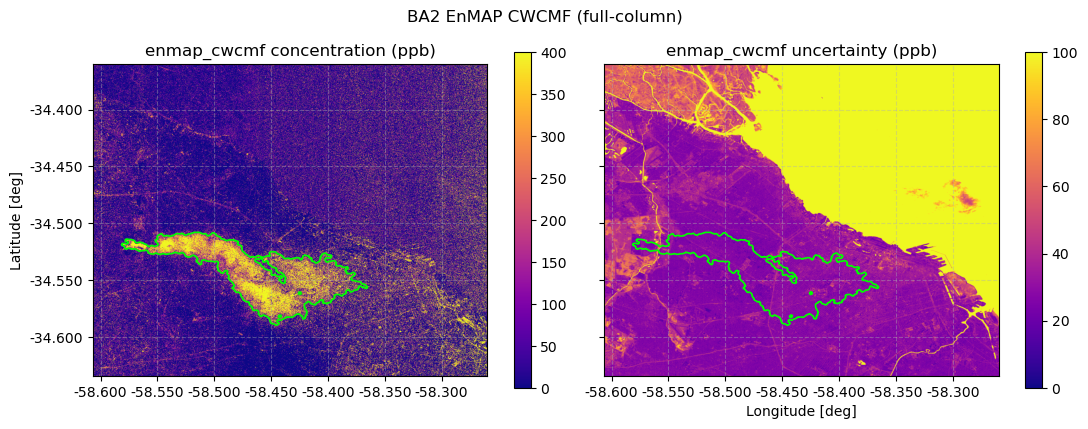

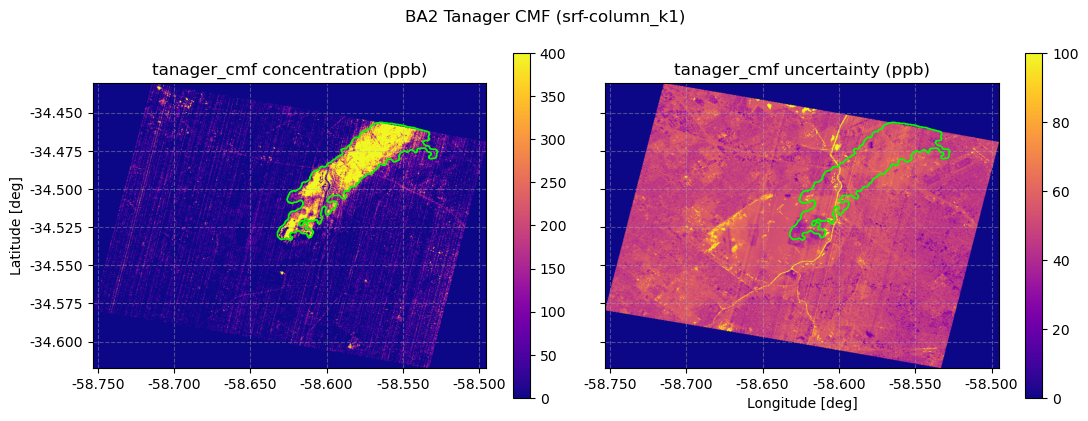

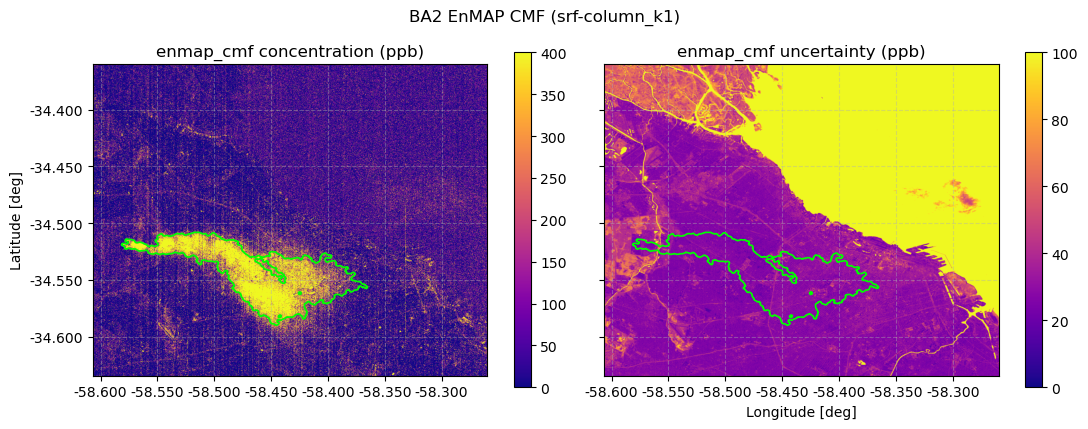

In [8]:
import matplotlib.ticker as mticker


def _extent_from_gt(gt, shape):
    x0, dx, _, y0, _, dy = gt
    h, w = shape
    x1 = x0 + dx * w
    y1 = y0 + dy * h
    return [x0, x1, y1, y0]


def _axis_labels(crs):
    if crs and getattr(crs, 'is_geographic', False):
        return 'Longitude [deg]', 'Latitude [deg]'
    return 'Easting', 'Northing'


def plot_plume_overlays(results, contour_color='lime', pct=99.0):
    for res in results:
        conc = res['concentration_ppb']
        unc = res['uncertainty_ppb']
        gt = res['geotransform']
        proj = res['projection']
        extent = _extent_from_gt(gt, conc.shape)
        x0, x1, y_min, y_max = extent
        x_coords = np.linspace(x0, x1, conc.shape[1])
        y_coords = np.linspace(y_max, y_min, conc.shape[0])

        gdf = gpd.read_file(res['vector_path'])
        raster_crs = CRS.from_wkt(proj) if proj else None
        if raster_crs:
            gdf = gdf.to_crs(raster_crs)
        mask = rasterize_gdf(gdf, gt, proj, conc.shape)

        def _auto(arr):
            try:
                v = float(np.nanpercentile(arr, pct))
            except Exception:
                v = None
            if not np.isfinite(v) or v <= 0:
                v = float(np.nanmax(arr)) if np.isfinite(np.nanmax(arr)) else None
            return v

        conc_vmax = _auto(conc)
        unc_vmax = _auto(unc)

        fig, axes = plt.subplots(1, 2, figsize=(11, 4.2), sharex=True, sharey=True)
        im0 = axes[0].imshow(np.ma.masked_invalid(conc), cmap='plasma', vmin=0, vmax=400, extent=extent, origin='upper')
        axes[0].contour(x_coords, y_coords, mask.astype(float), levels=[0.5], colors=contour_color, linewidths=1.2)
        axes[0].set_title(f"{res['label']} concentration (ppb)")
        plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.06)

        im1 = axes[1].imshow(np.ma.masked_invalid(unc), cmap='plasma', vmin=0, vmax=100, extent=extent, origin='upper')
        axes[1].contour(x_coords, y_coords, mask.astype(float), levels=[0.5], colors=contour_color, linewidths=1.2)
        axes[1].set_title(f"{res['label']} uncertainty (ppb)")
        plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.06)

        for ax in axes:
            ax.set_aspect('equal')
            ax.grid(True, linestyle='--', alpha=0.4)
            ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.3f'))
            ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.3f'))
        xl, yl = _axis_labels(raster_crs)
        axes[1].set_xlabel(xl)
        axes[0].set_ylabel(yl)
        fig.suptitle(res['scene'], fontsize=12)
        fig.tight_layout()
        plt.show()

plot_plume_overlays(all_results, contour_color='lime', pct=99.0)
